# ORB

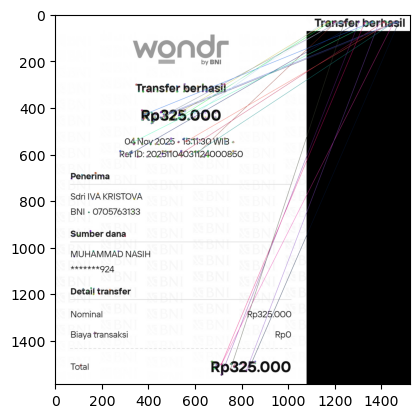

In [3]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('../input/new/template_01.jpg', 0)
img2 = cv2.imread('../input/new/transfer_berhasil.jpg', 0)

orb = cv2.ORB_create()

# detect + compute descriptors
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# match features
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key = lambda x:x.distance)

result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None)


plt.imshow(result)
plt.show()

# SIFT

In [1]:
import cv2

img1 = cv2.imread('../input/new/template_01.jpg', 0)
img2 = cv2.imread('../input/new/transfer_berhasil.jpg', 0)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

print("Matches:", len(good))

Matches: 426


---

COMPUTER VISION RECEIPT VERIFICATION PIPELINE DEMO

1. Creating demo receipt images...
Creating demo receipt images...
   Template size: (1000, 600, 3)
   User image size: (667, 400, 3)

2. Demonstrating feature matching...

3. Aligning images...
Template size: (800, 480), User size: (800, 479)
Template keypoints: 962, User keypoints: 949
Alignment successful! Used 266 good matches

4. Defining regions to verify...
   Defined 7 regions to verify

5. Detecting text regions...
   Found 12 text regions

6. Extracting text from regions...

--------------------------------------------------
TEXT EXTRACTION RESULTS:
--------------------------------------------------
   Bank Name:           'wr ee we F oe'
   Transaction Type:    'lerchant: Community Dues'
   Merchant:            'mount: Rp 250.000'
   Amount:              'RE: VO/Uls sULS 19° HN'
   Date:                'ee'
   Transaction ID:      'a'
   Status:              'Be'
--------------------------------------------------

7. Genera

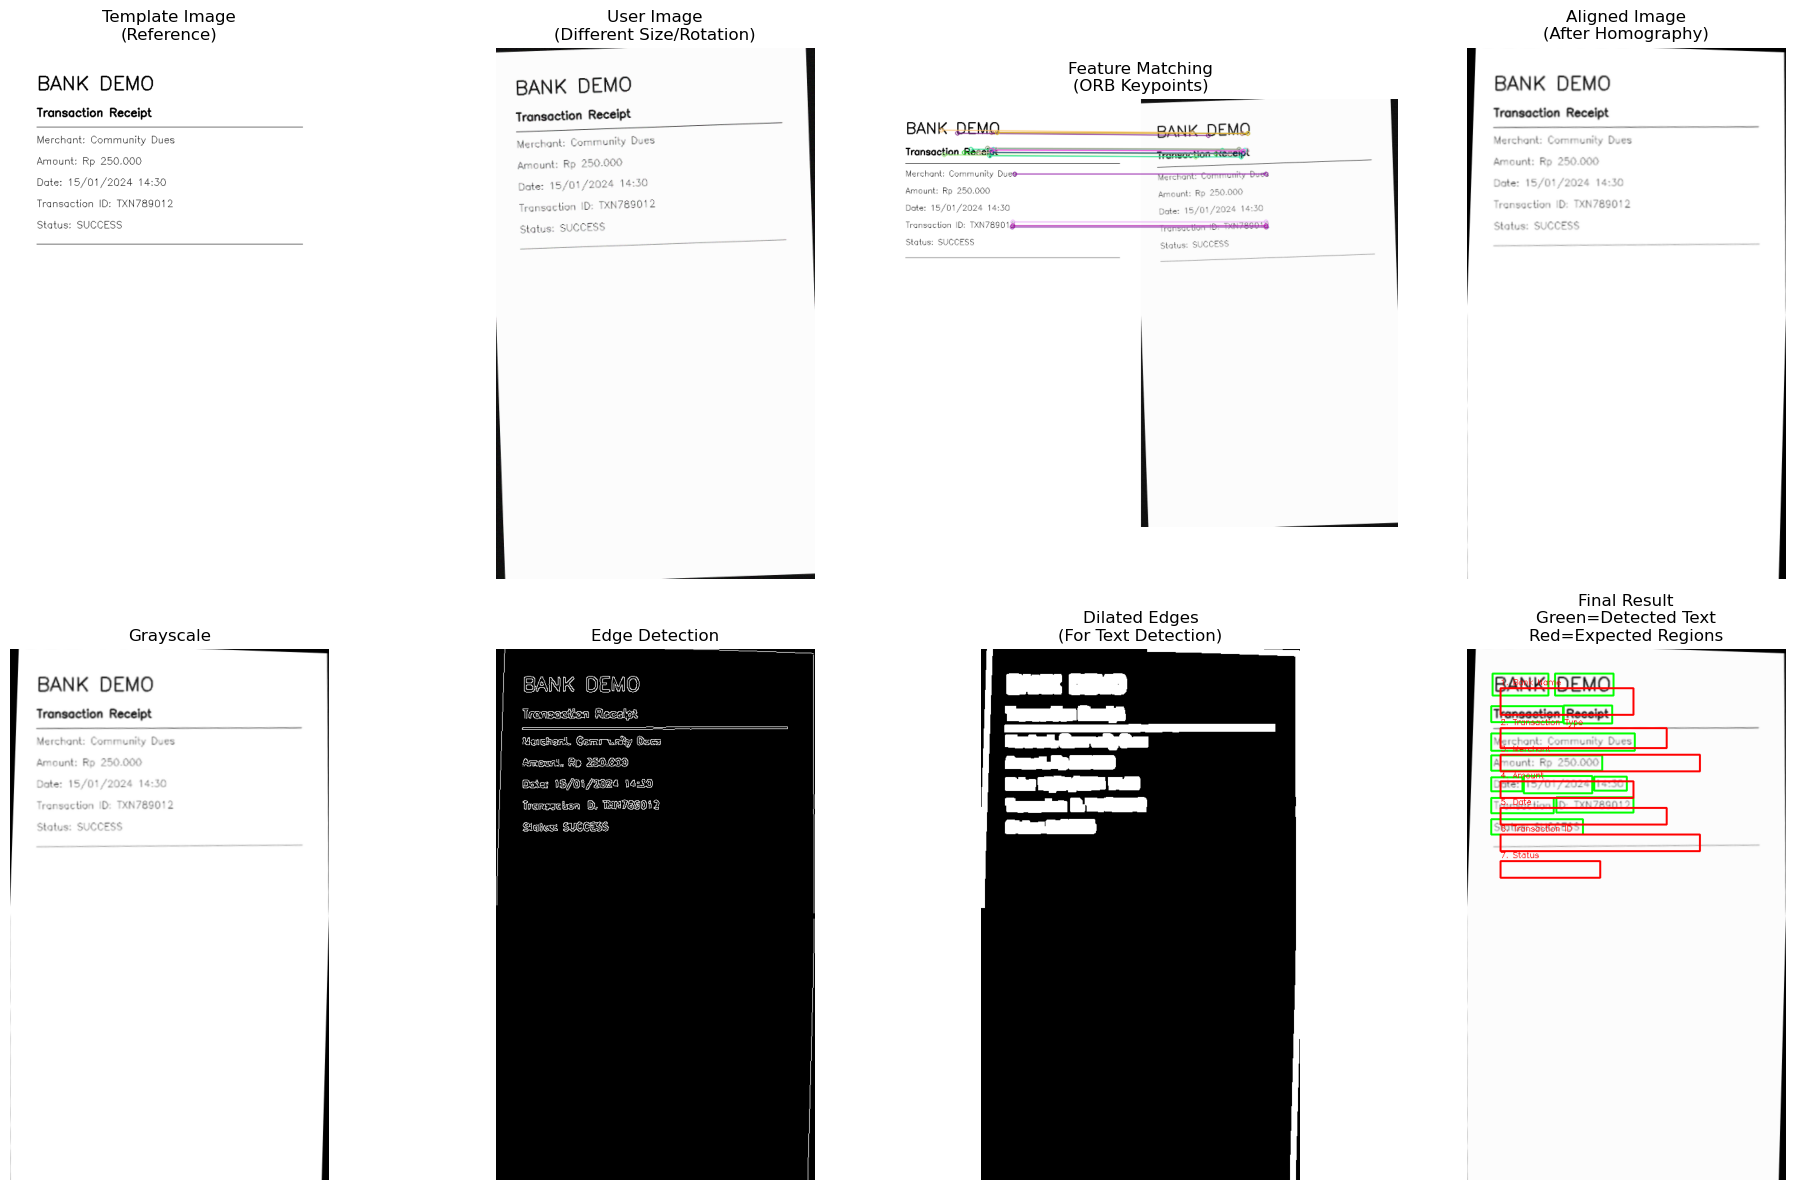


PIPELINE EXECUTION SUMMARY
✓ Template image: (1000, 600, 3)
✓ User image: (667, 400, 3)
✓ Feature matches: 266
✓ Text regions detected: 12
✓ Regions verified: 7
✓ Alignment: SUCCESS
✓ Result saved: pipeline_result.jpg

To use with your own images:
1. Replace 'your_template_receipt.jpg' and 'your_user_receipt.jpg'
2. Define your actual regions in 'test_with_your_own_images()'
3. Call test_with_your_own_images()


In [1]:
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import os

def preprocess_image(image):
    """Preprocess image for better feature detection"""
    # Resize to reasonable working size
    h, w = image.shape[:2]
    max_dim = 800
    scale = max_dim / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    
    # Convert to grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    return gray, scale, resized

def align_images(user_image, template_image):
    """Align user image to template using feature matching"""
    # Preprocess both images
    user_gray, user_scale, user_resized = preprocess_image(user_image)
    template_gray, template_scale, template_resized = preprocess_image(template_image)
    
    print(f"Template size: {template_gray.shape}, User size: {user_gray.shape}")
    
    # Initialize ORB detector
    orb = cv2.ORB_create(1000)
    
    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(template_gray, None)
    kp2, des2 = orb.detectAndCompute(user_gray, None)
    
    if des1 is None or des2 is None:
        print("Error: Not enough features detected!")
        return None, None, None, None
    
    print(f"Template keypoints: {len(kp1)}, User keypoints: {len(kp2)}")
    
    # Match features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    
    if len(matches) < 4:
        print(f"Error: Only {len(matches)} matches found. Need at least 4.")
        return None, None, None, None
    
    # Sort matches by distance (quality)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Take only the best matches (top 50%)
    good_matches = matches[:len(matches)//2]
    
    # Extract coordinates of matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Find homography matrix using RANSAC
    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    
    if M is None:
        print("Error: Could not compute homography!")
        return None, None, None, None
    
    # Warp the user image to align with template
    h, w = template_gray.shape
    aligned_image = cv2.warpPerspective(user_resized, M, (w, h))
    aligned_gray = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2GRAY)
    
    print(f"Alignment successful! Used {len(good_matches)} good matches")
    return aligned_gray, template_gray, M, good_matches

def detect_text_regions(image):
    """Your existing function - modified for grayscale"""
    # Create a color version for drawing
    if len(image.shape) == 2:
        original = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        original = image.copy()
    
    # Use grayscale for processing
    gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Noise reduction
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection (Canny)
    edges = cv2.Canny(blur, 50, 150)
    
    # Dilate edges to connect characters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)
    
    # Find contours (connected components)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Filtering rules (adjusted for normalized size)
        if w < 15 or h < 8:  # Reduced thresholds for smaller images
            continue
            
        ratio = w / float(h)
        if ratio < 0.2 or ratio > 15:
            continue
            
        area = w * h
        if area < 30 or area > image.shape[0] * image.shape[1] * 0.3:
            continue
            
        boxes.append((x, y, w, h))
        cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    return original, boxes, gray, edges, dilated

def extract_text_from_roi(aligned_image, x, y, w, h):
    """Extract text from a specific region"""
    # Ensure coordinates are within image bounds
    h_img, w_img = aligned_image.shape[:2] if len(aligned_image.shape) == 3 else aligned_image.shape
    x = max(0, min(x, w_img - 5))
    y = max(0, min(y, h_img - 5))
    w = max(5, min(w, w_img - x))
    h = max(5, min(h, h_img - y))
    
    roi = aligned_image[y:y+h, x:x+w]
    
    if roi.size == 0:
        return "NO TEXT"
    
    # Enhance ROI for better OCR
    roi_enhanced = cv2.resize(roi, (w*2, h*2))  # Scale up for better recognition
    _, roi_binary = cv2.threshold(roi_enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    try:
        # Use Tesseract with custom config
        custom_config = r'--oem 3 --psm 7'
        text = pytesseract.image_to_string(roi_binary, config=custom_config)
        return text.strip()
    except:
        return "OCR ERROR"

def create_demo_images():
    """Create realistic demo receipt images for testing"""
    print("Creating demo receipt images...")
    
    # Template image (larger - simulating high-res template)
    template = np.ones((1000, 600, 3), dtype=np.uint8) * 255  # White background
    
    # Add receipt elements
    cv2.putText(template, "BANK DEMO", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)
    cv2.putText(template, "Transaction Receipt", (50, 130), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(template, "Merchant: Community Dues", (50, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    cv2.putText(template, "Amount: Rp 250.000", (50, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    cv2.putText(template, "Date: 15/01/2024 14:30", (50, 260), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    cv2.putText(template, "Transaction ID: TXN789012", (50, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    cv2.putText(template, "Status: SUCCESS", (50, 340), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    
    # Add some decorative lines
    cv2.line(template, (50, 150), (550, 150), (0, 0, 0), 1)
    cv2.line(template, (50, 370), (550, 370), (0, 0, 0), 1)
    
    # User image (smaller - simulating different phone size)
    user_img = cv2.resize(template, (400, 667))  # Different aspect ratio
    
    # Add some realistic variations
    # 1. Add slight rotation
    center = (user_img.shape[1] // 2, user_img.shape[0] // 2)
    angle = 2  # 2 degrees rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    user_img = cv2.warpAffine(user_img, rotation_matrix, (user_img.shape[1], user_img.shape[0]))
    
    # 2. Add slight noise
    noise = np.random.randint(0, 15, user_img.shape, dtype=np.uint8)
    user_img = cv2.add(user_img, noise)
    
    # 3. Slight brightness variation
    user_img = cv2.convertScaleAbs(user_img, alpha=0.95, beta=10)
    
    return template, user_img

def demonstrate_feature_matching(template, user_img):
    """Show feature matching visualization"""
    # Preprocess for feature matching
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    user_gray = cv2.cvtColor(user_img, cv2.COLOR_BGR2GRAY)
    
    # Resize for consistent display
    template_gray = cv2.resize(template_gray, (400, 667))
    
    # ORB detector
    orb = cv2.ORB_create(500)
    kp1, des1 = orb.detectAndCompute(template_gray, None)
    kp2, des2 = orb.detectAndCompute(user_gray, None)
    
    # Match features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Draw matches
    match_img = cv2.drawMatches(template_gray, kp1, user_gray, kp2, 
                               matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return match_img

def run_complete_demo():
    """Run the complete pipeline demonstration"""
    print("=" * 60)
    print("COMPUTER VISION RECEIPT VERIFICATION PIPELINE DEMO")
    print("=" * 60)
    
    # Step 1: Create demo images
    print("\n1. Creating demo receipt images...")
    template, user_img = create_demo_images()
    
    # Save demo images
    cv2.imwrite('demo_template.jpg', template)
    cv2.imwrite('demo_user.jpg', user_img)
    
    print(f"   Template size: {template.shape}")
    print(f"   User image size: {user_img.shape}")
    
    # Step 2: Demonstrate feature matching
    print("\n2. Demonstrating feature matching...")
    match_img = demonstrate_feature_matching(template, user_img)
    
    # Step 3: Align images
    print("\n3. Aligning images...")
    aligned_gray, template_gray, M, matches = align_images(user_img, template)
    
    if aligned_gray is None:
        print("   Alignment failed! Using fallback method...")
        # Simple resize fallback
        aligned_gray = cv2.resize(cv2.cvtColor(user_img, cv2.COLOR_BGR2GRAY), 
                                (template_gray.shape[1], template_gray.shape[0]))
    
    # Step 4: Define regions to check (based on our template layout)
    print("\n4. Defining regions to verify...")
    regions_to_check = [
        {"name": "Bank Name", "x": 50, "y": 60, "w": 200, "h": 40},
        {"name": "Transaction Type", "x": 50, "y": 120, "w": 250, "h": 30},
        {"name": "Merchant", "x": 50, "y": 160, "w": 300, "h": 25},
        {"name": "Amount", "x": 50, "y": 200, "w": 200, "h": 25},
        {"name": "Date", "x": 50, "y": 240, "w": 250, "h": 25},
        {"name": "Transaction ID", "x": 50, "y": 280, "w": 300, "h": 25},
        {"name": "Status", "x": 50, "y": 320, "w": 150, "h": 25},
    ]
    
    print(f"   Defined {len(regions_to_check)} regions to verify")
    
    # Step 5: Detect text regions
    print("\n5. Detecting text regions...")
    result_image, detected_boxes, gray, edges, dilated = detect_text_regions(aligned_gray)
    print(f"   Found {len(detected_boxes)} text regions")
    
    # Convert to color for drawing
    if len(result_image.shape) == 2:
        result_image = cv2.cvtColor(result_image, cv2.COLOR_GRAY2BGR)
    aligned_color = cv2.cvtColor(aligned_gray, cv2.COLOR_GRAY2BGR)
    
    # Step 6: Extract and verify text from regions
    print("\n6. Extracting text from regions...")
    print("\n" + "-" * 50)
    print("TEXT EXTRACTION RESULTS:")
    print("-" * 50)
    
    verification_results = []
    
    for i, region in enumerate(regions_to_check):
        x, y, w, h = region["x"], region["y"], region["w"], region["h"]
        
        # Draw expected region (red)
        cv2.rectangle(aligned_color, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        
        # Extract text
        text = extract_text_from_roi(aligned_gray, x, y, w, h)
        
        # Add to results
        verification_results.append({
            'region': region['name'],
            'text': text,
            'position': (x, y)
        })
        
        # Print result
        print(f"   {region['name'] + ':':<20} '{text}'")
        
        # Add text to visualization
        cv2.putText(result_image, f"{i+1}. {region['name']}", 
                   (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
    
    print("-" * 50)
    
    # Step 7: Display comprehensive results
    print("\n7. Generating visualization...")
    
    plt.figure(figsize=(20, 12))
    
    # Original images
    plt.subplot(2, 4, 1)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title("Template Image\n(Reference)")
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(cv2.cvtColor(user_img, cv2.COLOR_BGR2RGB))
    plt.title("User Image\n(Different Size/Rotation)")
    plt.axis('off')
    
    # Feature matching
    plt.subplot(2, 4, 3)
    plt.imshow(match_img, cmap='gray')
    plt.title("Feature Matching\n(ORB Keypoints)")
    plt.axis('off')
    
    # Alignment result
    plt.subplot(2, 4, 4)
    plt.imshow(aligned_gray, cmap='gray')
    plt.title("Aligned Image\n(After Homography)")
    plt.axis('off')
    
    # Processing steps
    plt.subplot(2, 4, 5)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(dilated, cmap='gray')
    plt.title("Dilated Edges\n(For Text Detection)")
    plt.axis('off')
    
    # Final result
    plt.subplot(2, 4, 8)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Final Result\nGreen=Detected Text\nRed=Expected Regions")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Step 8: Summary
    print("\n" + "=" * 60)
    print("PIPELINE EXECUTION SUMMARY")
    print("=" * 60)
    print(f"✓ Template image: {template.shape}")
    print(f"✓ User image: {user_img.shape}")
    print(f"✓ Feature matches: {len(matches) if matches else 'N/A'}")
    print(f"✓ Text regions detected: {len(detected_boxes)}")
    print(f"✓ Regions verified: {len(regions_to_check)}")
    print(f"✓ Alignment: {'SUCCESS' if M is not None else 'FALLBACK'}")
    
    # Save result image
    cv2.imwrite('pipeline_result.jpg', result_image)
    print(f"✓ Result saved: pipeline_result.jpg")
    
    return verification_results

def test_with_your_own_images():
    """Template for testing with your own images"""
    template_path = "your_template_receipt.jpg"
    user_path = "your_user_receipt.jpg"
    
    if os.path.exists(template_path) and os.path.exists(user_path):
        template = cv2.imread(template_path)
        user_img = cv2.imread(user_path)
        
        # Define your actual regions based on your receipt layout
        your_regions = [
            # {"name": "Field Name", "x": 100, "y": 150, "w": 200, "h": 30},
            # Add your specific regions here
        ]
        
        # Run the same pipeline
        aligned_gray, template_gray, M, matches = align_images(user_img, template)
        # ... continue with the rest of the pipeline
        
    else:
        print("Please provide your own image paths")

# EXECUTE THE DEMO
# Run the complete demo
results = run_complete_demo()

print("\nTo use with your own images:")
print("1. Replace 'your_template_receipt.jpg' and 'your_user_receipt.jpg'")
print("2. Define your actual regions in 'test_with_your_own_images()'")
print("3. Call test_with_your_own_images()")